In [4]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
import os
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_tree


In [5]:
product_sale = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductSales.csv')
voucher_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\VoucherMapping.csv')
product_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductMapping.csv')

In [6]:
merged = product_sale.merge(voucher_map, on ='BillID', how='inner')[['BillID','TransactionDate','VoucherCampaignName','LEVEL_3','NetAmount', 'CustomerID','Channel']]

In [7]:
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
merged['Month'] = merged['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))
merged

,BillID,TransactionDate,VoucherCampaignName,LEVEL_3,NetAmount,CustomerID,Channel,Month
0,13,2021-01-01,Campaign 20,FESTIVE LTO 2021,0,17278,Take Away,01-2021
1,13,2021-01-01,Campaign 98,FESTIVE LTO 2021,0,17278,Take Away,01-2021
2,13,2021-01-01,Campaign 165,FESTIVE LTO 2021,0,17278,Take Away,01-2021
3,13,2021-01-01,Campaign 90,FESTIVE LTO 2021,0,17278,Take Away,01-2021
4,13,2021-01-01,Campaign 20,FESTIVE LTO 2021,408182,17278,Take Away,01-2021
...,...,...,...,...,...,...,...,...
22875,168417,2022-11-25,Campaign 87,B1G3,323148,15549,Delivery,11-2022
22876,168417,2022-11-25,Campaign 87,B1G3,0,15549,Delivery,11-2022
22877,168417,2022-11-25,Campaign 87,ADD-ON,45370,15549,Delivery,11-2022
22878,168417,2022-11-25,Campaign 87,ADD-ON,0,15549,Delivery,11-2022


In [8]:
def voucher_usage_rate(dim, value, df):
    num_bill_deli_tab = df.drop_duplicates('BillID').groupby('Month',as_index=False).agg(num_bill_deli = ('BillID','count'))
    num_bill_deli_VOUCHER_tab = df[df[dim] == value].drop_duplicates(subset=['BillID']).groupby('Month',as_index=False).agg(num_bill_deli_VOUCHER = ('BillID','count'))
    df = num_bill_deli_tab.merge(num_bill_deli_VOUCHER_tab, on = 'Month')
    df['delifee_voucher_usage_rate'] = df['num_bill_deli_VOUCHER'] / df['num_bill_deli']
    df = df.rename(columns={'delifee_voucher_usage_rate': f"{value}_voucher_usage_rate", "num_bill_deli_VOUCHER": f"num_bill_{value}_VOUCHER", "num_bill_deli": "num_bill"})
    return df

In [9]:
merged = product_sale.merge(voucher_map, on ='BillID', how='inner')[['BillID','TransactionDate','VoucherCampaignName','LEVEL_3','NetAmount', 'CustomerID','Channel']]
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
merged['Month'] = merged['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))
B1G3_TAB = voucher_usage_rate(dim = 'LEVEL_3', value = 'B1G3', df = merged)

In [10]:
merged = product_sale.merge(voucher_map, on ='BillID', how='inner')[['BillID','TransactionDate','VoucherCampaignName','LEVEL_3','NetAmount', 'CustomerID','Channel']]
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
merged['Month'] = merged['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))
DELIVERY_TAB = voucher_usage_rate(dim = 'LEVEL_3', value = 'DELIVERY FEE', df = merged)

In [11]:
merged = product_sale.merge(voucher_map, on ='BillID', how='inner')[['BillID','TransactionDate','VoucherCampaignName','LEVEL_3','NetAmount', 'CustomerID','Channel','LEVEL_2']]
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
merged['Month'] = merged['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))

def voucher_usage_rate(dim, value, df):
    num_bill_deli_tab = df.drop_duplicates('BillID').groupby('Month',as_index=False).agg(num_bill_deli = ('BillID','count'))
    num_bill_deli_VOUCHER_tab = df[(df[dim] == value)&(df['LEVEL_2'] == 'PIZZA')].drop_duplicates(subset=['BillID']).groupby('Month',as_index=False).agg(num_bill_deli_VOUCHER = ('BillID','count'))
    df = num_bill_deli_tab.merge(num_bill_deli_VOUCHER_tab, on = 'Month')
    df['delifee_voucher_usage_rate'] = df['num_bill_deli_VOUCHER'] / df['num_bill_deli']
    df = df.rename(columns={'delifee_voucher_usage_rate': f"{value}_voucher_usage_rate", "num_bill_deli_VOUCHER": f"num_bill_{value}_VOUCHER", "num_bill_deli": "num_bill"})
    return df


MENU_TAB = voucher_usage_rate(dim = 'LEVEL_3', value = 'MENU', df = merged)

In [12]:
final_merged = B1G3_TAB.merge(DELIVERY_TAB, on = 'Month').merge(MENU_TAB, on = 'Month')[['Month','num_bill_x','num_bill_B1G3_VOUCHER','B1G3_voucher_usage_rate','num_bill_DELIVERY FEE_VOUCHER','DELIVERY FEE_voucher_usage_rate','num_bill_MENU_VOUCHER','MENU_voucher_usage_rate']]

In [13]:
# final_merged.to_excel(r'percen_use_voucher.xlsx')

# 2 | For each segment

In [14]:
rfm_segment = pd.read_excel(r'C:\Users\Admin\RBAC\r3_segmentation1.xlsx', index_col=0)

In [15]:
merged = product_sale.merge(voucher_map, on ='BillID', how='inner')
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
merged['Month'] = merged['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))
cust_voucher = merged.merge(rfm_segment, on='CustomerID')
cust_voucher = cust_voucher[['BillID','TransactionDate','VoucherCampaignName','LEVEL_3','NetAmount', 'CustomerID','Channel','LEVEL_2','Month']]
cust_voucher

,BillID,TransactionDate,VoucherCampaignName,LEVEL_3,NetAmount,CustomerID,Channel,LEVEL_2,Month
0,13,2021-01-01,Campaign 20,FESTIVE LTO 2021,0,17278,Take Away,COMBO,01-2021
1,13,2021-01-01,Campaign 98,FESTIVE LTO 2021,0,17278,Take Away,COMBO,01-2021
2,13,2021-01-01,Campaign 165,FESTIVE LTO 2021,0,17278,Take Away,COMBO,01-2021
3,13,2021-01-01,Campaign 90,FESTIVE LTO 2021,0,17278,Take Away,COMBO,01-2021
4,13,2021-01-01,Campaign 20,FESTIVE LTO 2021,408182,17278,Take Away,COMBO,01-2021
...,...,...,...,...,...,...,...,...,...
22875,168392,2022-11-25,Campaign 46,NaN,369444,23774,Delivery,NaN,11-2022
22876,168392,2022-11-25,Campaign 46,NaN,0,23774,Delivery,NaN,11-2022
22877,168392,2022-11-25,Campaign 46,DELIVERY FEE,20370,23774,Delivery,DELIVERY FEE,11-2022
22878,168411,2022-11-25,Campaign 43,MENU,323148,1640,Delivery,PIZZA,11-2022


In [16]:
def voucher_usage_rate(dim, value, df):
    num_bill_deli_tab = df.drop_duplicates('BillID').groupby(['Month','CustomerID'],as_index=False).agg(num_bill_deli = ('BillID','count'))
    num_bill_deli_VOUCHER_tab = df[df[dim] == value].drop_duplicates(subset=['BillID']).groupby(['Month','CustomerID'],as_index=False).agg(num_bill_deli_VOUCHER = ('BillID','count'))
    df = num_bill_deli_tab.merge(num_bill_deli_VOUCHER_tab, on = ['Month','CustomerID'])
    df['delifee_voucher_usage_rate'] = df['num_bill_deli_VOUCHER'] / df['num_bill_deli']
    df = df.rename(columns={'delifee_voucher_usage_rate': f"{value}_voucher_usage_rate", "num_bill_deli_VOUCHER": f"num_bill_{value}_VOUCHER", "num_bill_deli": "num_bill"})
    return df

In [17]:
DELIVERY_TAB_CUST = voucher_usage_rate(dim = 'LEVEL_3', value = 'DELIVERY FEE', df = cust_voucher).sort_values('DELIVERY FEE_voucher_usage_rate').drop(['num_bill'], axis=1)

In [18]:
DELIVERY_TAB_CUST

,Month,CustomerID,num_bill_DELIVERY FEE_VOUCHER,DELIVERY FEE_voucher_usage_rate
688,05-2022,27611,1,0.333333
1438,09-2022,7017,1,0.333333
701,05-2022,30617,1,0.500000
1753,10-2022,18847,1,0.500000
542,05-2022,1920,1,0.500000
...,...,...,...,...
677,05-2022,25182,1,1.000000
676,05-2022,25001,1,1.000000
675,05-2022,24935,1,1.000000
689,05-2022,27759,1,1.000000


In [19]:
B1G3_TAB_CUST = voucher_usage_rate(dim = 'LEVEL_3', value = 'B1G3', df = cust_voucher).sort_values('B1G3_voucher_usage_rate').drop(['num_bill'], axis=1)
B1G3_TAB_CUST

,Month,CustomerID,num_bill_B1G3_VOUCHER,B1G3_voucher_usage_rate
591,09-2022,3153,1,0.333333
393,08-2022,6453,1,0.500000
710,09-2022,24349,1,0.500000
370,08-2022,4166,1,0.500000
367,08-2022,3060,1,0.500000
...,...,...,...,...
309,07-2022,24377,1,1.000000
310,07-2022,24379,1,1.000000
311,07-2022,24529,1,1.000000
300,07-2022,22284,1,1.000000


In [20]:
def voucher_usage_rate(dim, value, df):
    num_bill_deli_tab = df.drop_duplicates('BillID').groupby(['Month','CustomerID'],as_index=False).agg(num_bill_deli = ('BillID','count'))
    num_bill_deli_VOUCHER_tab = df[(df[dim] == value)&(df['LEVEL_2'] == 'PIZZA')].drop_duplicates(subset=['BillID']).groupby(['Month','CustomerID'],as_index=False).agg(num_bill_deli_VOUCHER = ('BillID','count'))
    df = num_bill_deli_tab.merge(num_bill_deli_VOUCHER_tab, on = ['Month','CustomerID'])
    df['delifee_voucher_usage_rate'] = df['num_bill_deli_VOUCHER'] / df['num_bill_deli']
    df = df.rename(columns={'delifee_voucher_usage_rate': f"{value}_voucher_usage_rate", "num_bill_deli_VOUCHER": f"num_bill_{value}_VOUCHER", "num_bill_deli": "num_bill"})
    return df

PizzaMenu_TAB_CUST = voucher_usage_rate(dim = 'LEVEL_3', value = 'MENU', df = cust_voucher).sort_values('MENU_voucher_usage_rate').drop(['num_bill'], axis=1)
PizzaMenu_TAB_CUST

,Month,CustomerID,num_bill_MENU_VOUCHER,MENU_voucher_usage_rate
360,09-2022,3153,1,0.333333
329,08-2022,24553,1,0.500000
111,05-2022,4124,1,0.500000
337,08-2022,26969,1,0.500000
115,05-2022,7526,1,0.500000
...,...,...,...,...
193,07-2022,16568,1,1.000000
194,07-2022,17747,1,1.000000
195,07-2022,18312,1,1.000000
189,07-2022,15532,1,1.000000


In [21]:
temp = product_sale[['TransactionDate','CustomerID']]
temp['TransactionDate'] = pd.to_datetime(temp['TransactionDate'])
temp['Month'] = temp['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))
temp = temp[['CustomerID','Month']].drop_duplicates(subset=['CustomerID','Month'])
temp

C:\Users\Admin\AppData\Local\Temp\ipykernel_14220\4227458893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['TransactionDate'] = pd.to_datetime(temp['TransactionDate'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_14220\4227458893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Month'] = temp['TransactionDate'].apply(lambda x: x.strftime('%m-%Y'))


,CustomerID,Month
0,6402,01-2021
6,884,01-2021
11,16274,01-2021
17,28546,01-2021
24,14373,01-2021
...,...,...
762042,19065,11-2022
762048,6687,11-2022
762053,2733,11-2022
762058,20614,11-2022


In [22]:
voucher_use_cust = temp.merge(DELIVERY_TAB_CUST,
                                            on = ['CustomerID', 'Month'], how  = 'left').merge(B1G3_TAB_CUST,
                                                                                                                 on = ['CustomerID', 'Month'], how  = 'left').merge(PizzaMenu_TAB_CUST,
                                                                                                                                                                    on = ['CustomerID', 'Month'], how  = 'left')

In [23]:
voucher_use_cust = voucher_use_cust.fillna(0)
voucher_use_cust

,CustomerID,Month,num_bill_DELIVERY FEE_VOUCHER,DELIVERY FEE_voucher_usage_rate,num_bill_B1G3_VOUCHER,B1G3_voucher_usage_rate,num_bill_MENU_VOUCHER,MENU_voucher_usage_rate
0,6402,01-2021,0.0,0.0,0.0,0.0,0.0,0.0
1,884,01-2021,0.0,0.0,0.0,0.0,0.0,0.0
2,16274,01-2021,0.0,0.0,0.0,0.0,0.0,0.0
3,28546,01-2021,0.0,0.0,0.0,0.0,0.0,0.0
4,14373,01-2021,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
124515,19065,11-2022,0.0,0.0,0.0,0.0,0.0,0.0
124516,6687,11-2022,0.0,0.0,0.0,0.0,0.0,0.0
124517,2733,11-2022,0.0,0.0,0.0,0.0,0.0,0.0
124518,20614,11-2022,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# voucher_use_cust.to_excel(r'percen_use_voucher_cust.xlsx')

# 3 | Campaign formance

In [25]:
from datetime import datetime
product_sale['TransactionDate'] = pd.to_datetime(product_sale['TransactionDate'], format=r'%m/%d/%Y')

# Create a new column "QuarterYear" combining Quarter and Year
product_sale['QuarterYear'] = product_sale['TransactionDate'].dt.to_period("Q").astype(str)
product_sale

,BillID,TransactionDate,TransactionTime,Channel,OrderFrom,FatherCode,FoodCode,ItemTotalQuantity,NetAmount,LEVEL_1,LEVEL_2,LEVEL_3,CustomerID,QuarterYear
0,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,3304,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402,2021Q1
1,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,3316,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402,2021Q1
2,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,2018,1,38182,PROMOTION,BOGO,BOGO REGULAR 2020,6402,2021Q1
3,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,320,1,36364,PROMOTION,BOGO,BOGO REGULAR 2020,6402,2021Q1
4,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,2468,1,190000,PROMOTION,BOGO,BOGO REGULAR 2020,6402,2021Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762068,168433,2022-11-25,16:54,Delivery,STORE,3438.0,3438,1,20370,DELIVERY FEE,DELIVERY FEE,DELIVERY FEE,10882,2022Q4
762069,168434,2022-11-25,17:50,Take Away,STORE,2049.0,2049,1,0,PROMOTION,B1G3,B1G3,14672,2022Q4
762070,168434,2022-11-25,17:50,Take Away,STORE,2049.0,2058,1,323148,PROMOTION,B1G3,B1G3,14672,2022Q4
762071,168434,2022-11-25,17:50,Take Away,STORE,2049.0,2069,1,0,PROMOTION,B1G3,B1G3,14672,2022Q4


In [26]:
voucher_order = voucher_map.merge(product_sale, on = 'BillID')

In [27]:
TotalNetAmount_tab = voucher_order.groupby(['QuarterYear','VoucherCampaignName'], as_index=False).agg(TotalNetAmount = ('NetAmount', 'sum'))

In [28]:
temp = voucher_order.drop_duplicates(
    subset=['FatherCode','VoucherCampaignName']).groupby(
        ['BillID','VoucherCampaignName','QuarterYear'],as_index=False).agg(
            NumUsedInOrder=('FoodCode','count'))

TotalTimeUsed_tab = temp.groupby(['VoucherCampaignName','QuarterYear'], as_index=False).agg(TotalTimeUsed = ('NumUsedInOrder','sum'))

In [29]:
DistinctCustomer_tab = voucher_order.drop_duplicates(subset=['CustomerID','BillID']).groupby(['QuarterYear','VoucherCampaignName'], as_index=False).agg(DistinctCustomer = ('CustomerID', 'count'))

In [30]:
temp_1 = voucher_order.groupby(['QuarterYear','VoucherCampaignName'], as_index=False).agg(TotalNetAmount = ('NetAmount', 'sum'), TotalVoucherValueSpent = ('VoucherValue','sum'))
temp_1['AbsoluteSales_on_VoucherValue'] = (temp_1['TotalNetAmount'] + temp_1['TotalVoucherValueSpent']) / temp_1['TotalVoucherValueSpent']
AOV_tab = temp_1[['VoucherCampaignName','QuarterYear','AbsoluteSales_on_VoucherValue','TotalVoucherValueSpent']]

In [31]:
CamPerformance = TotalNetAmount_tab.merge(TotalTimeUsed_tab, 
                         on = ['QuarterYear','VoucherCampaignName']).merge(DistinctCustomer_tab,
                                                                           on = ['QuarterYear','VoucherCampaignName']).merge(AOV_tab,
                                                                                                                             on = ['QuarterYear','VoucherCampaignName'])

In [32]:
# CamPerformance.to_excel('CamPerformance.xlsx')

In [33]:
CamPerformance.sort_values(['QuarterYear','VoucherCampaignName'])

,QuarterYear,VoucherCampaignName,TotalNetAmount,TotalTimeUsed,DistinctCustomer,AbsoluteSales_on_VoucherValue,TotalVoucherValueSpent
0,2021Q1,Campaign 1,745454,3,2,2.490908,500000.0
1,2021Q1,Campaign 10,2982589,16,1,2.084578,2750000.0
2,2021Q1,Campaign 101,325454,1,1,4.254540,100000.0
3,2021Q1,Campaign 102,1731820,2,1,2.731820,1000000.0
4,2021Q1,Campaign 104,99091,1,1,1.990910,100000.0
...,...,...,...,...,...,...,...
954,2022Q4,Campaign 95,1621293,2,4,1.853312,1900000.0
955,2022Q4,Campaign 96,1581388,9,4,1.878549,1800000.0
956,2022Q4,Campaign 97,1396294,3,4,1.821349,1700000.0
957,2022Q4,Campaign 98,1435182,5,4,1.574073,2500000.0


# 4 | Combo perforamance

In [34]:
merged = product_sale.merge(product_map, on = 'FoodCode', how = 'left')
Bill_ID_Combo = merged[merged['CATEGORIES'] == 'COMBO']['BillID'].unique()

In [35]:
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
TotalComboVal_tab = merged[merged['BillID'].isin(Bill_ID_Combo)].groupby('TransactionDate', as_index=False).agg(TotalComboVal = ('NetAmount','sum'))

In [36]:
Total_NonCombo_Val_tab = merged[merged['BillID'].isin(Bill_ID_Combo) == 0].groupby('TransactionDate', as_index=False).agg(Total_NonCombo_Val = ('NetAmount','sum'))

In [37]:
temp = TotalComboVal_tab.merge(Total_NonCombo_Val_tab, on = 'TransactionDate')
temp['Combo_on_NonCombo'] = temp['TotalComboVal'] / temp['Total_NonCombo_Val']

In [38]:
temp

,TransactionDate,TotalComboVal,Total_NonCombo_Val,Combo_on_NonCombo
0,2021-01-01,21738363,219924150,0.098845
1,2021-01-02,9061818,152288663,0.059504
2,2021-01-03,7854543,145330034,0.054046
3,2021-01-04,5976817,83751525,0.071364
4,2021-01-05,3427864,62757809,0.054621
...,...,...,...,...
686,2022-11-21,5949996,12213197,0.487178
687,2022-11-22,7760174,15542496,0.499288
688,2022-11-23,4850599,12046855,0.402644
689,2022-11-24,8071430,17646154,0.457404


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

<Axes: xlabel='TransactionDate', ylabel='Combo_on_NonCombo'>

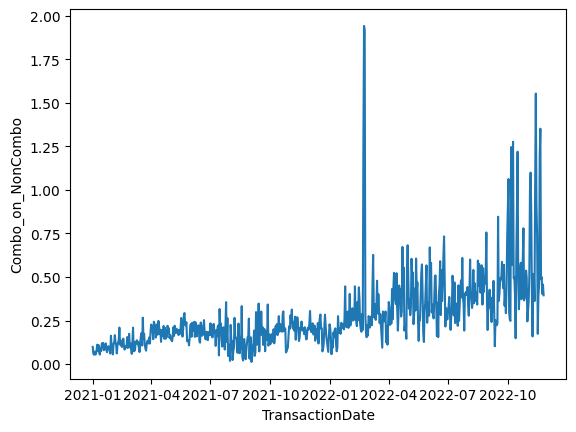

In [39]:
sns.lineplot(
    data = temp,
    x = 'TransactionDate',
    y = 'Combo_on_NonCombo'
)

## 4.1 | Segmenting combo

In [40]:
FatherCode_Combo = merged[merged['CATEGORIES'] == 'COMBO']['FatherCode'].unique()

In [58]:
temp = merged[merged['FatherCode'].isin(FatherCode_Combo)].groupby(['BillID','FatherCode','TransactionDate','CustomerID'], as_index=False).agg(ValueOrder = ('NetAmount','sum'))
temp.sort_values(['BillID','FatherCode'])

,BillID,FatherCode,TransactionDate,CustomerID,ValueOrder
0,15,3157.0,2021-01-01,21278,337273
1,19,3264.0,2021-01-01,29553,300909
2,20,3157.0,2021-01-01,22467,337273
3,21,3157.0,2021-01-01,4309,381818
4,23,3395.0,2021-01-01,9164,246364
...,...,...,...,...,...
41706,168425,1470.0,2022-11-25,5400,202778
41707,168426,1337.0,2022-11-25,26645,369444
41708,168429,2416.0,2022-11-25,19065,662964
41709,168431,1337.0,2022-11-25,2733,369444


In [42]:
FatherCode_Combo_AvgValue = temp.groupby('FatherCode', as_index=False).agg(ComboAvgValue = ('ValueOrder','mean'))

In [43]:
quan_val = []
for q in [0.333,0.666,0.999]:
    quan_val.append(np.quantile(FatherCode_Combo_AvgValue['ComboAvgValue'].values, q))
FatherCode_Combo_AvgValue['Combo_Segment'] = FatherCode_Combo_AvgValue['ComboAvgValue'].apply(lambda x: 'Small' if x <= quan_val[0] 
                                                                                                                    else ("Regular" if x <= quan_val[1]
                                                                                                                        else 'Large'))

In [44]:
quan_val

[216702.00294117647, 348306.45263157896, 3324564.7204545406]

In [45]:
FatherCode_Combo_AvgValue

,FatherCode,ComboAvgValue,Combo_Segment
0,0.0,92535.836207,Small
1,22.0,369444.000000,Large
2,46.0,369444.000000,Large
3,49.0,290669.958084,Regular
4,110.0,176099.159483,Small
...,...,...,...
146,3264.0,326868.081412,Regular
147,3395.0,212016.378291,Small
148,3614.0,448394.585014,Large
149,3616.0,369801.177419,Large


## 4.2 | Segmenting customer base on avg order value

In [51]:
RFM_VALUE = pd.read_excel(r'C:\Users\Admin\RBAC\RFM_Value_Extracted_xlsx.xlsx', index_col=0)
segment_df = pd.read_excel(r'C:\Users\Admin\RBAC\r3_segmentation1.xlsx', index_col=0)

In [52]:
quan_val = []
for q in [0.333,0.666,0.999]:
    quan_val.append(np.quantile(RFM_VALUE['avg_value_per_order'].values, q))
RFM_VALUE['Customer_OrderValue_Segment'] = RFM_VALUE['avg_value_per_order'].apply(lambda x: 'Small_Cust' if x <= quan_val[0] 
                                                                                                                    else ("Regular_Cust" if x <= quan_val[1]
                                                                                                                        else 'Large_Cust'))

In [53]:
RFM_VALUE_refined = RFM_VALUE[['CustomerID','Customer_OrderValue_Segment','avg_value_per_order']]

In [54]:
combo_cust = temp.merge(FatherCode_Combo_AvgValue, on = 'FatherCode').merge(RFM_VALUE_refined, on = 'CustomerID').merge(segment_df, on = 'CustomerID')

In [55]:
combo_cust

,BillID,FatherCode,TransactionDate,CustomerID,ValueOrder,ComboAvgValue,Combo_Segment,Customer_OrderValue_Segment,avg_value_per_order,Cluster,segment,Favourite_piz_size,favourite_voucher_lv1,favourite_voucher_lv2,favourite_channel
0,15,3157.0,2021-01-01,21278,337273,488900.827818,Large,Large_Cust,433939.111111,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
1,44924,3157.0,2021-05-09,21278,453636,488900.827818,Large,Large_Cust,433939.111111,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
2,65847,3157.0,2021-07-04,21278,355455,488900.827818,Large,Large_Cust,433939.111111,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
3,66179,3157.0,2021-07-05,21278,632726,488900.827818,Large,Large_Cust,433939.111111,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
4,20,3157.0,2021-01-01,22467,337273,488900.827818,Large,Regular_Cust,301818.666667,Single_item_prefered,hibernating,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_STORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41706,167831,1554.0,2022-11-19,9419,340741,348586.947368,Large,Regular_Cust,324480.500000,Single_item_prefered,champions,REGULAR,PROMOTION,PROMOTION_BOGO,Take Away_STORE
41707,168011,1554.0,2022-11-20,6295,276852,348586.947368,Large,Regular_Cust,297222.000000,Single_item_prefered,new customer,REGULAR,DELIVERY FEE,DELIVERY FEE_DELIVERY FEE,Delivery_WEBSITE
41708,168024,1554.0,2022-11-20,194,276852,348586.947368,Large,Small_Cust,261351.250000,Combo_prefered,potential,REGULAR,PROMOTION,PROMOTION_BOGO,Take Away_STORE
41709,168104,1554.0,2022-11-20,19812,276852,348586.947368,Large,Regular_Cust,297222.000000,Single_item_prefered,new customer,REGULAR,DELIVERY FEE,DELIVERY FEE_DELIVERY FEE,Delivery_APP


In [57]:
# combo_cust.to_excel(r'Combo_cust.xlsx')

## 4.3 | New combo cust

In [74]:
product_sale = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductSales.csv')
voucher_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\VoucherMapping.csv')
product_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductMapping.csv')

In [75]:
merged = product_sale.merge(product_map, on='FoodCode', how='left')
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])

In [76]:
FatherCode_Combo = merged[merged['CATEGORIES'] == 'COMBO']['FatherCode'].unique()
Combo_order = merged[merged['FatherCode'].isin(FatherCode_Combo)]['BillID'].unique()

In [77]:
new_combo_cust_tab = merged.groupby(['BillID','FatherCode','TransactionDate','CustomerID'], as_index=False).agg(ValueOrder = ('NetAmount','sum'))
new_combo_cust_tab['Combo_order?'] = 0
new_combo_cust_tab['Combo_order?'][new_combo_cust_tab['BillID'].isin(Combo_order)] = 1
new_combo_cust_tab

C:\Users\Admin\AppData\Local\Temp\ipykernel_14220\213182921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_combo_cust_tab['Combo_order?'][new_combo_cust_tab['BillID'].isin(Combo_order)] = 1


,BillID,FatherCode,TransactionDate,CustomerID,ValueOrder,Combo_order?
0,0,3304.0,2021-01-01,6402,264546,0
1,0,3438.0,2021-01-01,6402,20000,0
2,1,3055.0,2021-01-01,884,264546,0
3,2,3303.0,2021-01-01,16274,246364,0
4,2,3438.0,2021-01-01,16274,20000,0
...,...,...,...,...,...,...
319501,168431,3438.0,2022-11-25,2733,20370,1
319502,168432,3614.0,2022-11-25,20614,479630,1
319503,168433,2048.0,2022-11-25,10882,184259,0
319504,168433,3438.0,2022-11-25,10882,20370,0


In [78]:
new_combo_cust_tab_merged = new_combo_cust_tab.merge(FatherCode_Combo_AvgValue, 
                            on ='FatherCode', how='left').merge(RFM_VALUE_refined,
                                                                on ='CustomerID', how='left').merge(segment_df, 
                                                                                                    on = 'CustomerID', how='left')

In [79]:
new_combo_cust_tab_merged

,BillID,FatherCode,TransactionDate,CustomerID,ValueOrder,Combo_order?,ComboAvgValue,Combo_Segment,Customer_OrderValue_Segment,avg_value_per_order,Cluster,segment,Favourite_piz_size,favourite_voucher_lv1,favourite_voucher_lv2,favourite_channel
0,0,3304.0,2021-01-01,6402,264546,0,NaN,NaN,Regular_Cust,287171.666667,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
1,0,3438.0,2021-01-01,6402,20000,0,NaN,NaN,Regular_Cust,287171.666667,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
2,1,3055.0,2021-01-01,884,264546,0,NaN,NaN,Regular_Cust,293240.833333,Single_item_prefered,potential,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE
3,2,3303.0,2021-01-01,16274,246364,0,NaN,NaN,Large_Cust,380799.750000,Single_item_prefered,about to sleep,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
4,2,3438.0,2021-01-01,16274,20000,0,NaN,NaN,Large_Cust,380799.750000,Single_item_prefered,about to sleep,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319501,168431,3438.0,2022-11-25,2733,20370,1,NaN,NaN,Regular_Cust,349439.750000,Single_item_prefered,potential,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE
319502,168432,3614.0,2022-11-25,20614,479630,1,448394.585014,Large,Large_Cust,418178.750000,Single_item_prefered,champions,REGULAR,ALC,ALC_PIZZA,Dine In_STORE
319503,168433,2048.0,2022-11-25,10882,184259,0,NaN,NaN,Large_Cust,375563.272727,Single_item_prefered,champions,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_STORE
319504,168433,3438.0,2022-11-25,10882,20370,0,NaN,NaN,Large_Cust,375563.272727,Single_item_prefered,champions,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_STORE


In [83]:
new_combo_cust_tab_merged[
    new_combo_cust_tab_merged['segment'] == 'do not lose'
    ].sort_values('TransactionDate')

,BillID,FatherCode,TransactionDate,CustomerID,ValueOrder,Combo_order?,ComboAvgValue,Combo_Segment,Customer_OrderValue_Segment,avg_value_per_order,Cluster,segment,Favourite_piz_size,favourite_voucher_lv1,favourite_voucher_lv2,favourite_channel
0,0,3304.0,2021-01-01,6402,264546,0,NaN,NaN,Regular_Cust,287171.666667,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
832,408,2153.0,2021-01-01,10728,100000,0,NaN,NaN,Large_Cust,443668.555556,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
833,408,2745.0,2021-01-01,10728,26364,0,NaN,NaN,Large_Cust,443668.555556,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
834,408,3304.0,2021-01-01,10728,228182,0,NaN,NaN,Large_Cust,443668.555556,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
844,415,3304.0,2021-01-01,8042,263637,0,NaN,NaN,Regular_Cust,289659.125000,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225172,117447,3438.0,2022-02-27,7822,20370,1,NaN,NaN,Large_Cust,556310.000000,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE
225173,117448,3395.0,2022-02-27,7822,202778,1,212016.378291,Small,Large_Cust,556310.000000,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE
225174,117448,3438.0,2022-02-27,7822,20370,1,NaN,NaN,Large_Cust,556310.000000,Single_item_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE
224985,117350,3303.0,2022-02-27,23343,269445,0,NaN,NaN,Regular_Cust,278637.000000,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter


In [80]:
# new_combo_cust_tab_merged.to_excel(r'new_combo_cust_tab_merged.xlsx')

In [90]:
temp = product_sale.merge(segment_df, on ='CustomerID')
temp['TransactionDate'] = pd.to_datetime(temp['TransactionDate'])
temp[temp['segment'] == 'do not lose'].sort_values('TransactionDate')

,BillID,TransactionDate,TransactionTime,Channel,OrderFrom,FatherCode,FoodCode,ItemTotalQuantity,NetAmount,LEVEL_1,LEVEL_2,LEVEL_3,CustomerID,Cluster,segment,Favourite_piz_size,favourite_voucher_lv1,favourite_voucher_lv2,favourite_channel
0,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,3304,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
3860,128,2021-01-01,10:39,Take Away,STORE,3158.0,701,1,262727,PROMOTION,BOGO,BOGO LARGE 2020,2047,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
3861,128,2021-01-01,10:39,Take Away,STORE,3158.0,2861,1,38182,PROMOTION,BOGO,BOGO LARGE 2020,2047,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
3862,128,2021-01-01,10:39,Take Away,STORE,3158.0,1451,1,0,PROMOTION,BOGO,BOGO LARGE 2020,2047,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
3863,128,2021-01-01,10:39,Take Away,STORE,3158.0,3158,1,0,PROMOTION,BOGO,BOGO LARGE 2020,2047,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560050,117272,2022-02-27,18:35,Take Away,STORE,3158.0,3158,2,0,PROMOTION,BOGO,BOGO LARGE 2020,9366,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
560049,117272,2022-02-27,18:35,Take Away,STORE,3158.0,1621,1,0,PROMOTION,BOGO,BOGO LARGE 2020,9366,Combo_prefered,do not lose,LARGE,PROMOTION,PROMOTION_BOGO,Take Away_STORE
57913,117554,2022-02-27,11:39,Delivery,WEBSITE,2416.0,95,1,0,COMBO,MY BOX,MY BOX,10354,Single_item_prefered,do not lose,REGULAR,ALC,COMBO_MY BOX,Food Aggregators_AGG-SHOPEEFOOD
703480,117641,2022-02-27,11:32,Delivery,WEBSITE,3055.0,2635,1,45370,PROMOTION,BOGO,REGULAR BOGO,3580,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_WEBSITE


In [91]:
temp

,BillID,TransactionDate,TransactionTime,Channel,OrderFrom,FatherCode,FoodCode,ItemTotalQuantity,NetAmount,LEVEL_1,LEVEL_2,LEVEL_3,CustomerID,Cluster,segment,Favourite_piz_size,favourite_voucher_lv1,favourite_voucher_lv2,favourite_channel
0,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,3304,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
1,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,3316,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
2,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,2018,1,38182,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
3,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,320,1,36364,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
4,0,2021-01-01,10:09,Delivery,CallCenter,3304.0,2468,1,190000,PROMOTION,BOGO,BOGO REGULAR 2020,6402,Single_item_prefered,do not lose,REGULAR,PROMOTION,PROMOTION_BOGO,Delivery_CallCenter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762068,168401,2022-11-25,18:36,Delivery,WEBSITE,2049.0,224,1,0,PROMOTION,B1G3,B1G3,22663,Single_item_prefered,new customer,LARGE,PROMOTION,PROMOTION_B1G3,Delivery_WEBSITE
762069,168401,2022-11-25,18:36,Delivery,WEBSITE,2049.0,2122,1,323148,PROMOTION,B1G3,B1G3,22663,Single_item_prefered,new customer,LARGE,PROMOTION,PROMOTION_B1G3,Delivery_WEBSITE
762070,168401,2022-11-25,18:36,Delivery,WEBSITE,2410.0,2410,1,0,ALC,OTHERS,ADD-ON,22663,Single_item_prefered,new customer,LARGE,PROMOTION,PROMOTION_B1G3,Delivery_WEBSITE
762071,168401,2022-11-25,18:36,Delivery,WEBSITE,2410.0,386,1,45370,ALC,OTHERS,ADD-ON,22663,Single_item_prefered,new customer,LARGE,PROMOTION,PROMOTION_B1G3,Delivery_WEBSITE
